# Quantum Programming Lab3

In [91]:
from qiskit import *
from qiskit_aer import AerSimulator
import numpy as np
from qiskit.quantum_info import Operator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

## Part 1: Quantum circuit for Shor's algorithm

Construct a compiled version of quantum circuit for Shor's algorithm.

Shor's algorithm consists of the following steps; choose a co-prime 
$a$, where $a \in [2,N-1]$ and the greatest common divisor of  $a$ and $N$ is 1, find the order of $a$ modulo $N$, the smallest integer $r$
such that $a^r \mod N=1$, and then obtain the factor of $N$ by computing the greatst common divisor of $a^{r/2} \pm 1$ and $N$. In this procedure, the second step, finding the order of $a$ modulo $N$, is the only quantum part, quantum order-finding.

In Ch.3.9 Shor's Algorithm https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/shor.ipynb,
we built a quantum circuit to find the order for $a=7$ and $N=15$. However, as we are very well aware by now, such a large depth circuit is not practical to run on near-term quantum systems due to the presence of noise. Here in part 1 of this lab, we construct a practical quantum circuit for the same example, which could generate a meaningful solution when executed on today's quantum computers.

In general, the quantum order-finding circuit to factorize the number $N$ requires $m=\log_2(N)$ qubits in the computational (auxiliary) register and 
$2m(=t)$ qubit in the period (counting) registers .i.e. total $3m$ qubits, at minimum. Therefore, $12$ qubits were used in the quantum circuit to factorize the number 15 in Shor's Algorithm. In addition, the cotrolled unitary operator for the modular function, $f(x)=a^{x} \mod N$ was applied in a cascading manner as shown in the figure below to produce the highly entangled state $\sum_{x=0}^{2^m-1}\ket{x}\ket{a^x \mod N}$, which increseas the circuit depth substantially. However the size of the circuit can be reduced based on several observations.

### StepA:  Run the following cell to create the gate $U$ for the function $7\mod15$.
The unitary operator $U$ is defined as $U\ket{x}\equiv \ket{7x(\mod 15)}$

In [92]:
## Create 7mod15 gate
N = 15
m = int(np.ceil(np.log2(N)))

U_qc = QuantumCircuit(m)
U_qc.x(range(m))
U_qc.swap(1, 2)
U_qc.swap(2, 3)
U_qc.swap(0, 3)
U_qc.draw(output = 'mpl')
U = U_qc.to_gate()
U.name ='{}Mod{}'.format(7, N)

Confirm if the unitary operator works properly by creating a quantum circuit with $m$ qubits. Prepare the input state representing any integer between 0 and 15 (exclusive) such as $\ket{1}(=\ket{0001})$, $\ket{5}(=\ket{0101})$, $\ket{13}(=\ket{0101})$ etc, and apply $U$ gate on it. Check if the circuit produces the expected outcomes for several inputs. The outcome state for the input $\ket{1}$ should be $\ket{7}(=\ket{0111})$ and 
 $\ket{1}$ for the input $\ket{13}$, for example.

In [93]:
## Your code here
backend = AerSimulator()

#testing for |1>
qc_testU1 = QuantumCircuit(m,m)
qc_testU1.x(0) #gives us |0001> = 1
qc_testU1.append(U, range(m))
for i in range(m):
    qc_testU1.measure(i,i)
tc1 = transpile(qc_testU1, backend)
job = backend.run(tc1, shots=1000, memory=True)
count_QPE= job.result().get_counts()
print(count_QPE)

#testing for |13>
qc_testU2 = QuantumCircuit(m,m)
qc_testU2.x(0)
qc_testU2.x(2)
qc_testU2.x(3) #this gives |1101> = 13
qc_testU2.append(U, range(m))
for i in range(m):
    qc_testU2.measure(i,i)
tc2 = transpile(qc_testU2, backend)
job = backend.run(tc2, shots=1000, memory=True)
count_QPE= job.result().get_counts()
print(count_QPE)


{'0111': 1000}
{'0001': 1000}


### StepB:  Create a quantum circuit with $m$ qubits implementing $U$ gate $4=2^2$ times and run it using Operator(Which was imported in the first code block) to obtain the matrix resprentation of the gates in the circuit. Verify $U^{2^2}=I$


As shown in the above figure, modular exponentiation is realized by implementing the controlled unitary operator on each qubit 
$2^n$ times in series when $n$ goes from $0$ to $7$ for our example. However, we will find out that whole sets of operations are redundant when 
$n>1$ for $7\mod15$ case, hence the redundant operation can be removed from the circuit.

In [94]:
## Your code here
qcb = QuantumCircuit(m) #circuit applying U 4 times
qcb_id = QuantumCircuit(m) #circuit applying Identity
for i in range(4):
    qcb.append(U, range(m))
op = Operator(qcb) #operator of U circuit
op_identity = Operator(qcb_id) #operator of Identity
print((op == op_identity)) #check if these two operators are equal



True


### StepC: Run the cells below to see the reduced circuit, shor_QPE, and execute it on the qasm_simulator to check if it reproduce the estimated phases in the Qiskit textbook https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/quantum-phase-estimation.ipynb

In [95]:
def cU_multi(k):
    circ = QuantumCircuit(m)
    for _ in range(2**k):
        circ.append(U, range(m))
    
    U_multi = circ.to_gate()
    U_multi.name = '7Mod15_[2^{}]'.format(k)
    
    cU_multi = U_multi.control()
    return cU_multi

In [96]:
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

In [97]:
# QPE circuit for Shor
t = 3 
shor_QPE = QuantumCircuit(t+m, t)
shor_QPE.h(range(t))

shor_QPE.x(t)
for idx in range(t-1):
    shor_QPE.append(cU_multi(idx), [idx]+ list(range(t,t+m)))

qft_dag = qft(t).inverse()
qft_dag.name = 'QFT+'

shor_QPE.append(qft_dag, range(t))
shor_QPE.measure(range(t), range(t))

shor_QPE.draw()

┌───┐                                  ┌───────┐┌─┐      
q_0: ┤ H ├────────■─────────────────────────┤0      ├┤M├──────
     ├───┤        │                         │       │└╥┘┌─┐   
q_1: ┤ H ├────────┼────────────────■────────┤1 QFT+ ├─╫─┤M├───
     ├───┤        │                │        │       │ ║ └╥┘┌─┐
q_2: ┤ H ├────────┼────────────────┼────────┤2      ├─╫──╫─┤M├
     ├───┤┌───────┴───────┐┌───────┴───────┐└───────┘ ║  ║ └╥┘
q_3: ┤ X ├┤0              ├┤0              ├──────────╫──╫──╫─
     └───┘│               ││               │          ║  ║  ║ 
q_4: ─────┤1              ├┤1              ├──────────╫──╫──╫─
          │  7Mod15_[2^0] ││  7Mod15_[2^1] │          ║  ║  ║ 
q_5: ─────┤2              ├┤2              ├──────────╫──╫──╫─
          │               ││               │          ║  ║  ║ 
q_6: ─────┤3              ├┤3              ├──────────╫──╫──╫─
          └───────────────┘└───────────────┘          ║  ║  ║ 
c: 3/═════════════════════════════════════════════════╩══╩══╩═
                                                      0  1  2

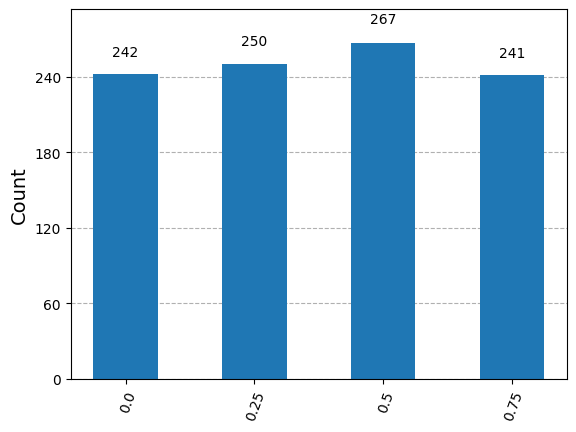

In [98]:
backend = AerSimulator()

transpiled_circuit = transpile(shor_QPE, backend)
job = backend.run(transpiled_circuit, shots=1000, memory=True)
count_QPE= job.result().get_counts()

key_new = [str(int(key,2)/2**3) for key in count_QPE.keys()]
count_new_QPE = dict(zip(key_new, count_QPE.values()))
plot_histogram(count_new_QPE)

## Part 2: Noisy simulation of the quantum order-finding circuits.

Goal

Perform the noise simulaton of all two quantum order-finding circuits: shor_Orig, shor_QPE. 
Compare their results.
After this experiment, hopefully you will get better understand why we still need quantum error correction to factor large integer.
A famous paper that I recommend you to read:
https://arxiv.org/abs/1905.09749

In [99]:
t = 2*m

shor_Orig = QuantumCircuit(t+m, t)
shor_Orig.h(range(t))

shor_Orig.x(t)
for idx in range(t):
    shor_Orig.append(cU_multi(idx), [idx]+ list(range(t,t+m)))

qft_dag = qft(t).inverse()
qft_dag.name = 'QFT+'

shor_Orig.append(qft_dag, range(t))
shor_Orig.measure(range(t), range(t))
    
shor_Orig.draw()

┌───┐                                                                    »
 q_0: ┤ H ├────────■───────────────────────────────────────────────────────────»
      ├───┤        │                                                           »
 q_1: ┤ H ├────────┼────────────────■──────────────────────────────────────────»
      ├───┤        │                │                                          »
 q_2: ┤ H ├────────┼────────────────┼────────────────■─────────────────────────»
      ├───┤        │                │                │                         »
 q_3: ┤ H ├────────┼────────────────┼────────────────┼────────────────■────────»
      ├───┤        │                │                │                │        »
 q_4: ┤ H ├────────┼────────────────┼────────────────┼────────────────┼────────»
      ├───┤        │                │                │                │        »
 q_5: ┤ H ├────────┼────────────────┼────────────────┼────────────────┼────────»
      ├───┤        │                │                │                │        »
 q_6: ┤ H ├────────┼────────────────┼────────────────┼────────────────┼────────»
      ├───┤        │                │                │                │        »
 q_7: ┤ H ├────────┼────────────────┼────────────────┼────────────────┼────────»
      ├───┤┌───────┴───────┐┌───────┴───────┐┌───────┴───────┐┌───────┴───────┐»
 q_8: ┤ X ├┤0              ├┤0              ├┤0              ├┤0              ├»
      └───┘│               ││               ││               ││               │»
 q_9: ─────┤1              ├┤1              ├┤1              ├┤1              ├»
           │  7Mod15_[2^0] ││  7Mod15_[2^1] ││  7Mod15_[2^2] ││  7Mod15_[2^3] │»
q_10: ─────┤2              ├┤2              ├┤2              ├┤2              ├»
           │               ││               ││               ││               │»
q_11: ─────┤3              ├┤3              ├┤3              ├┤3              ├»
           └───────────────┘└───────────────┘└───────────────┘└───────────────┘»
 c: 8/═════════════════════════════════════════════════════════════════════════»
                                                                               »
«                                                                          »
« q_0: ────────────────────────────────────────────────────────────────────»
«                                                                          »
« q_1: ────────────────────────────────────────────────────────────────────»
«                                                                          »
« q_2: ────────────────────────────────────────────────────────────────────»
«                                                                          »
« q_3: ────────────────────────────────────────────────────────────────────»
«                                                                          »
« q_4: ────────■───────────────────────────────────────────────────────────»
«              │                                                           »
« q_5: ────────┼────────────────■──────────────────────────────────────────»
«              │                │                                          »
« q_6: ────────┼────────────────┼────────────────■─────────────────────────»
«              │                │                │                         »
« q_7: ────────┼────────────────┼────────────────┼────────────────■────────»
«      ┌───────┴───────┐┌───────┴───────┐┌───────┴───────┐┌───────┴───────┐»
« q_8: ┤0              ├┤0              ├┤0              ├┤0              ├»
«      │               ││               ││               ││               │»
« q_9: ┤1              ├┤1              ├┤1              ├┤1              ├»
«      │  7Mod15_[2^4] ││  7Mod15_[2^5] ││  7Mod15_[2^6] ││  7Mod15_[2^7] │»
«q_10: ┤2              ├┤2              ├┤2              ├┤2              ├»
«      │               ││               ││               ││               │»
«q_11: ┤3              ├┤3              ├┤3     

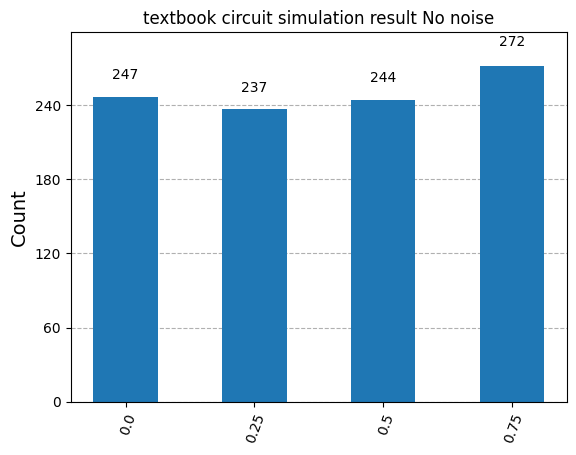

In [100]:
backend = AerSimulator()

transpiled_circuit = transpile(shor_Orig, backend)
job = backend.run(transpiled_circuit, shots=1000, memory=True)
count_Orig= job.result().get_counts()

key_new = [str(int(key,2)/2**t) for key in count_Orig.keys()]
count_Orig = dict(zip(key_new, count_Orig.values()))
plot_histogram(count_Orig, title='textbook circuit simulation result No noise')

#### Your task: Perform the noise simulations of all two circuits, shor_Orig, shor_QPE, with the noise model that we provide you here and run your simulation for different noise parameters p =[0.1,0.2,0.3,0.4,0.5] plot their noise simulation results together with ones without noise for comparison.

In [101]:
# Import from Qiskit Aer noise module
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)


def construct_bitphaseflip_noise_model(p):
    # We set three different noise parameter the same as p
    p_reset = p
    p_meas = p
    p_gate1 = p

    #Phase flip noise when there is gate of measurement
    error_reset = pauli_error([('Z', p_reset), ('I', 1 - p_reset)])
    error_meas = pauli_error([('Z',p_meas), ('I', 1 - p_meas)])
    error_gate1 = pauli_error([('Z',p_gate1), ('I', 1 - p_gate1)])
    error_gate2 = error_gate1.tensor(error_gate1)

    #Bitflip noise when there is gate of measurement
    error_reset_bit = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
    error_meas_bit = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1_bit = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
    error_gate2_bit = error_gate1_bit.tensor(error_gate1)

    # Add above errors to the same noise model object
    noise_bitphase_flip = NoiseModel()
    noise_bitphase_flip.add_all_qubit_quantum_error(error_reset_bit, "reset")
    noise_bitphase_flip.add_all_qubit_quantum_error(error_meas_bit, "measure")
    noise_bitphase_flip.add_all_qubit_quantum_error(error_gate1_bit, ["x","h","t","tdg"])
    noise_bitphase_flip.add_all_qubit_quantum_error(error_gate2_bit, ["cx,ccx"])
    

    return noise_bitphase_flip

Setup your noisemodel with noise parameter

In [102]:
p=0
noisemodel=construct_bitphaseflip_noise_model(p)

ShorOrigin figure creation. If they are not loading, the figures get progressivley super noisy with it becoming pretty indistinguishable around p=.3

In [124]:
backend = AerSimulator()
transpiled_circuit = transpile(shor_Orig, backend)

p_arr = [0,.1,.2,.3,.4,.5]
for p in p_arr:
    noisemodel = construct_bitphaseflip_noise_model(p)
    job = backend.run(transpiled_circuit,noise_model=noisemodel, shots=1000, memory=True)
    count_Orig= job.result().get_counts()
    key_new = [str(int(key,2)/2**8) for key in count_Orig.keys()]
    count_Orig = dict(zip(key_new, count_Orig.values()))
    if p>0:
        plot_title = "textbook circuit simulation with noise p=" + str(p)
    else:
        plot_title = "textbook circuit simulation with no noise"
    temp = plot_histogram(count_Orig, title=plot_title)
    fig_title = "Figures/ShorOrig_" + str(p) + "_.png"
    temp.savefig(fig_title)

![title](Figures/ShorOrig_0_.png)
![title](Figures/ShorOrig_0.1_.png)
![title](Figures/ShorOrig_0.2_.png)
![title](Figures/ShorOrig_0.3_.png)
![title](Figures/ShorOrig_0.4_.png)
![title](Figures/ShorOrig_0.5_.png)

The textbook circuit simulation is particularly noisy, especially with values > .02 for p. It is very hard to tell what phase values should be expected when the noise is past this threshold

ShorQPE figure creation. If they are not loading, the figures are much better than ShorOrigin in terms of noise on extraneous results although at p=.4 the noisy results become indistinguishable from the expected results in terms of amplitude

In [104]:
backend = AerSimulator()
transpiled_circuit = transpile(shor_QPE, backend)

p_arr = [0,.1,.2,.3,.4,.5]
for p in p_arr:
    noisemodel = construct_bitphaseflip_noise_model(p)
    job = backend.run(transpiled_circuit,noise_model=noisemodel, shots=1000, memory=True)
    count_Orig= job.result().get_counts()
    key_new = [str(int(key,2)/2**8) for key in count_Orig.keys()]
    count_Orig = dict(zip(key_new, count_Orig.values()))
    plot_title = "QPE circuit simulation with noise p=" + str(p)
    temp = plot_histogram(count_Orig, title=plot_title)
    fig_title = "ShorQPE_" + str(p) + "_.png"
    temp.savefig(fig_title)

![title](Figures/ShorQPE_0_.png)
![title](Figures/ShorQPE_0.1_.png)
![title](Figures/ShorQPE_0.2_.png)
![title](Figures/ShorQPE_0.3_.png)
![title](Figures/ShorQPE_0.4_.png)
![title](Figures/ShorQPE_0.5_.png)

### The QPE simulation is better than the textbook mainly due to the fact that the noise is less distributed. The expected phase values still have clearly higher counts until p>=.4

## Additional task: Do the lab two more times, but these times for N=21 and N=63. Describe any major differences in behavior between these cases.

First, we add a modification of function cU_multi to _cU_multi, by setting both U and m as parameters:

In [105]:
def _cU_multi(U,m,k):
    circ = QuantumCircuit(m)
    for _ in range(2**k):
        circ.append(U, range(m))
    
    U_multi = circ.to_gate()
    U_multi.name = '7Mod15_[2^{}]'.format(k)
    
    cU_multi = U_multi.control()
    return cU_multi

Here I give you an example of the Shor15 function. This is the exact format we expect you to implement for N=21 and N=63.
You might use any base $a$ as you like for modular exponential. 

In [111]:
def Shor15():
    ## Code for constructing shor_QPE for factoring 15 starts here
    a = 7
    N = 15
    m = int(np.ceil(np.log2(N)))
    
    U_qc = QuantumCircuit(m)
    U_qc.x(range(m))
    U_qc.swap(1, 2)
    U_qc.swap(2, 3)
    U_qc.swap(0, 3)
    
    U = U_qc.to_gate()
    U.name ='{}Mod{}'.format(7, N)

    # QPE circuit for Shor15
    t = 3 
    shor_QPE = QuantumCircuit(t+m, t)
    shor_QPE.h(range(t))
    
    shor_QPE.x(t)
    for idx in range(t-1):
        shor_QPE.append(_cU_multi(U,m,idx), [idx]+ list(range(t,t+m)))
    
    qft_dag = qft(t).inverse()
    qft_dag.name = 'QFT+'
    
    shor_QPE.append(qft_dag, range(t))
    shor_QPE.measure(range(t), range(t))
    ## Code for constructing shor_QPE for factoring 15 ends here    
    
    backend = AerSimulator()
    transpiled_circuit = transpile(shor_QPE, backend)
    job = backend.run(transpiled_circuit, shots=1000, memory=True)
    count_QPE= job.result().get_counts()
    return a, shor_QPE, count_QPE


Shor15()
#a,circ,counts = Shor15()
#circ.draw(output = 'mpl')

(7,
 {'100': 269, '000': 247, '010': 243, '110': 241})

Please implement the following function of factoring 21. 
You should submit this function in .py file.

In [ ]:
def Shor21():
    ##Your circuit for creating quantum circuit shor_QPT of factoring 21 starts here
    a = 8 # By default, you can use a=2 
    N = 21
    m = int(np.ceil(np.log2(N)))
    
    U_qc = QuantumCircuit(m)
    U_qc.x(4)
    U_qc.x(2)
    U_qc.x(0)
    # U_qc.swap(3,4) #need to figure out how to make the swap circuit
    # U_qc.swap(2,3)
    # U_qc.swap(1,2)
    # U_qc.swap(0,1)

    U = U_qc.to_gate()
    U.name ='{}Mod{}'.format(2, N)

    t = 4
    shor_QPE = QuantumCircuit(t+m, t)
    shor_QPE.h(range(t))
    shor_QPE.x(t)

    for idx in range(t-1):
        shor_QPE.append(_cU_multi(U,m,idx), [idx]+ list(range(t,t+m)))
    
    qft_dag = qft(t).inverse()
    qft_dag.name = 'QFT+'
    
    shor_QPE.append(qft_dag, range(t))
    shor_QPE.measure(range(t), range(t))
        
    ##Your circuit for creating quantum circuit shor_QPT of factoring 21 ends here    
    backend = AerSimulator()
    transpiled_circuit = transpile(shor_QPE, backend)
    job = backend.run(transpiled_circuit, shots=1000, memory=True)
    count_QPE= job.result().get_counts()
    return a, shor_QPE, count_QPE

#a,b,c= Shor21()
#b.draw()

┌───┐                                                   ┌───────┐┌─┐      »
q_0: ┤ H ├────────■──────────────────────────────────────────┤0      ├┤M├──────»
     ├───┤        │                                          │       │└╥┘┌─┐   »
q_1: ┤ H ├────────┼────────────────■─────────────────────────┤1      ├─╫─┤M├───»
     ├───┤        │                │                         │  QFT+ │ ║ └╥┘┌─┐»
q_2: ┤ H ├────────┼────────────────┼────────────────■────────┤2      ├─╫──╫─┤M├»
     ├───┤        │                │                │        │       │ ║  ║ └╥┘»
q_3: ┤ H ├────────┼────────────────┼────────────────┼────────┤3      ├─╫──╫──╫─»
     ├───┤┌───────┴───────┐┌───────┴───────┐┌───────┴───────┐└───────┘ ║  ║  ║ »
q_4: ┤ X ├┤0              ├┤0              ├┤0              ├──────────╫──╫──╫─»
     └───┘│               ││               ││               │          ║  ║  ║ »
q_5: ─────┤1              ├┤1              ├┤1              ├──────────╫──╫──╫─»
          │               ││               ││               │          ║  ║  ║ »
q_6: ─────┤2 7Mod15_[2^0] ├┤2 7Mod15_[2^1] ├┤2 7Mod15_[2^2] ├──────────╫──╫──╫─»
          │               ││               ││               │          ║  ║  ║ »
q_7: ─────┤3              ├┤3              ├┤3              ├──────────╫──╫──╫─»
          │               ││               ││               │          ║  ║  ║ »
q_8: ─────┤4              ├┤4              ├┤4              ├──────────╫──╫──╫─»
          └───────────────┘└───────────────┘└───────────────┘          ║  ║  ║ »
c: 4/══════════════════════════════════════════════════════════════════╩══╩══╩═»
                                                                       0  1  2 »
«        
«q_0: ───
«        
«q_1: ───
«        
«q_2: ───
«     ┌─┐
«q_3: ┤M├
«     └╥┘
«q_4: ─╫─
«      ║ 
«q_5: ─╫─
«      ║ 
«q_6: ─╫─
«      ║ 
«q_7: ─╫─
«      ║ 
«q_8: ─╫─
«      ║ 
«c: 4/═╩═
«      3

### Major differences in Shor21():

For this case. I used a=8 which generates an expected period (r value) of 2. Therefore, on a non-noisy simulation all of the counts fall on the phase values of 0 and 0.5. The QPE simulations are noisier, and there are more phase values that counts are distributed to making the algorithim perform worse on this value than 15. this is mainly because an extra bit is needed to represent numbers 16-31

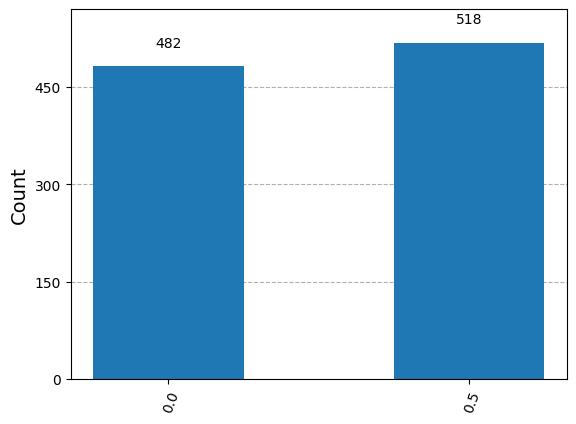

In [156]:
backend = AerSimulator()

transpiled_circuit = transpile(b, backend)
job = backend.run(transpiled_circuit, shots=1000, memory=True)
count_QPE= job.result().get_counts()

key_new = [str(int(key,2)/2**4) for key in count_QPE.keys()]
count_new_QPE = dict(zip(key_new, count_QPE.values()))
plot_histogram(count_new_QPE)

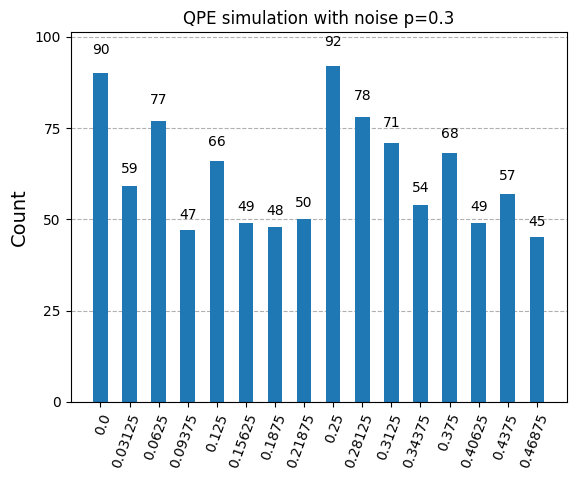

In [158]:
transpiled_circuit = transpile(b, backend)
p=0.3
noisemodel = construct_bitphaseflip_noise_model(p)
job = backend.run(transpiled_circuit,noise_model=noisemodel, shots=1000, memory=True)
count_Orig= job.result().get_counts()
key_new = [str(int(key,2)/2**5) for key in count_Orig.keys()]
count_Orig = dict(zip(key_new, count_Orig.values()))
if p>0:
    plot_title = "QPE simulation with noise p=" + str(p)
else:
    plot_title = "QPE simulation with no noise"
plot_histogram(count_Orig, title=plot_title)

Please implement the following function of factoring 63. 
You should submit this function in .py file.

In [ ]:
def Shor63():
    ##Your circuit for creating quantum circuit shor_QPT of factoring 63 starts here
    shor_QPE=None
    a = 8 # By default, you can use a=2    
    N = 63
    m = int(np.ceil(np.log2(N)))
    
    U_qc = QuantumCircuit(m)
    U_qc.x(range(m))
    # U_qc.swap(3,4) #need to figure out how to make the swap circuit
    # U_qc.swap(2,3)
    # U_qc.swap(1,2)
    # U_qc.swap(0,1)

    U = U_qc.to_gate()
    U.name ='{}Mod{}'.format(2, N)

    t = 5
    shor_QPE = QuantumCircuit(t+m, t)
    shor_QPE.h(range(t))
    shor_QPE.x(t)

    for idx in range(t-1):
        shor_QPE.append(_cU_multi(U,m,idx), [idx]+ list(range(t,t+m)))
    
    qft_dag = qft(t).inverse()
    qft_dag.name = 'QFT+'
    
    shor_QPE.append(qft_dag, range(t))
    shor_QPE.measure(range(t), range(t))
    
    ##Your circuit for creating quantum circuit shor_QPT of factoring 63 ends here    
    backend = AerSimulator()
    transpiled_circuit = transpile(shor_QPE, backend)
    job = backend.run(transpiled_circuit, shots=1000, memory=True)
    count_QPE= job.result().get_counts()
    return a, shor_QPE, count_QPE

#shor_QPE.draw()

┌───┐                                                                    »
q_0: ┤ H ├────────■───────────────────────────────────────────────────────────»
     ├───┤        │                                                           »
q_1: ┤ H ├────────┼────────────────■──────────────────────────────────────────»
     ├───┤        │                │                                          »
q_2: ┤ H ├────────┼────────────────┼────────────────■─────────────────────────»
     ├───┤        │                │                │                         »
q_3: ┤ H ├────────┼────────────────┼────────────────┼────────────────■────────»
     ├───┤        │                │                │                │        »
q_4: ┤ H ├────────┼────────────────┼────────────────┼────────────────┼────────»
     ├───┤┌───────┴───────┐┌───────┴───────┐┌───────┴───────┐┌───────┴───────┐»
q_5: ┤ X ├┤0              ├┤0              ├┤0              ├┤0              ├»
     └───┘│               ││               ││               ││               │»
q_6: ─────┤1              ├┤1              ├┤1              ├┤1              ├»
          │               ││               ││               ││               │»
q_7: ─────┤2 7Mod15_[2^0] ├┤2 7Mod15_[2^1] ├┤2 7Mod15_[2^2] ├┤2 7Mod15_[2^3] ├»
          │               ││               ││               ││               │»
q_8: ─────┤3              ├┤3              ├┤3              ├┤3              ├»
          │               ││               ││               ││               │»
q_9: ─────┤4              ├┤4              ├┤4              ├┤4              ├»
          └───────────────┘└───────────────┘└───────────────┘└───────────────┘»
c: 5/═════════════════════════════════════════════════════════════════════════»
                                                                              »
«     ┌───────┐┌─┐            
«q_0: ┤0      ├┤M├────────────
«     │       │└╥┘┌─┐         
«q_1: ┤1      ├─╫─┤M├─────────
«     │       │ ║ └╥┘┌─┐      
«q_2: ┤2 QFT+ ├─╫──╫─┤M├──────
«     │       │ ║  ║ └╥┘┌─┐   
«q_3: ┤3      ├─╫──╫──╫─┤M├───
«     │       │ ║  ║  ║ └╥┘┌─┐
«q_4: ┤4      ├─╫──╫──╫──╫─┤M├
«     └───────┘ ║  ║  ║  ║ └╥┘
«q_5: ──────────╫──╫──╫──╫──╫─
«               ║  ║  ║  ║  ║ 
«q_6: ──────────╫──╫──╫──╫──╫─
«               ║  ║  ║  ║  ║ 
«q_7: ──────────╫──╫──╫──╫──╫─
«               ║  ║  ║  ║  ║ 
«q_8: ──────────╫──╫──╫──╫──╫─
«               ║  ║  ║  ║  ║ 
«q_9: ──────────╫──╫──╫──╫──╫─
«               ║  ║  ║  ║  ║ 
«c: 5/══════════╩══╩══╩══╩══╩═
«               0  1  2  3  4

### Major differences in Shor63():

For this case I also used a=8 which generates an expected period (r value) of 2. Therefore, on a non-noisy simulation all of the counts fall on the phase values of 0 and 0.5. The QPE simulations are much noisier than 15 and 23, and there are more phase values that counts are distributed to making the algorithim perform worse on this value than both values. This illustrates the (current) issues with aplpying Shor's algorithims in useful cases.

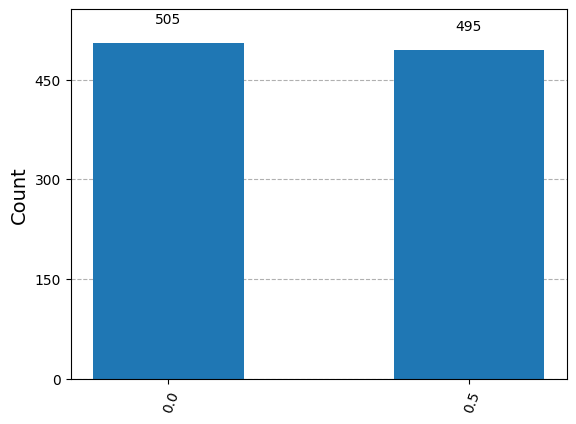

In [143]:
backend = AerSimulator()

transpiled_circuit = transpile(b, backend)
job = backend.run(transpiled_circuit, shots=1000, memory=True)
count_QPE= job.result().get_counts()

key_new = [str(int(key,2)/2**5) for key in count_QPE.keys()]
count_new_QPE = dict(zip(key_new, count_QPE.values()))
plot_histogram(count_new_QPE)

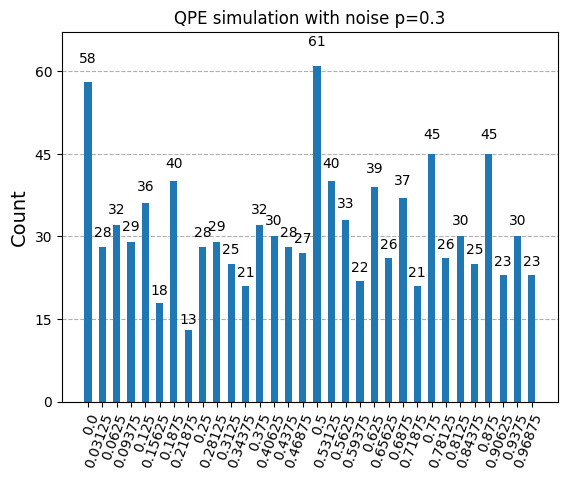

In [159]:
transpiled_circuit = transpile(shor_QPE, backend)
p=0.3
noisemodel = construct_bitphaseflip_noise_model(p)
job = backend.run(transpiled_circuit,noise_model=noisemodel, shots=1000, memory=True)
count_Orig= job.result().get_counts()
key_new = [str(int(key,2)/2**5) for key in count_Orig.keys()]
count_Orig = dict(zip(key_new, count_Orig.values()))
if p>0:
    plot_title = "QPE simulation with noise p=" + str(p)
else:
    plot_title = "QPE simulation with no noise"
plot_histogram(count_Orig, title=plot_title)

# Testing code is below:

In [150]:
from qiskit import *
from qiskit_aer import AerSimulator
import numpy as np
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import math
from termcolor import colored


def _cU_multi(U,m,k):
    circ = QuantumCircuit(m)
    for _ in range(2**k):
        circ.append(U, range(m))
    
    U_multi = circ.to_gate()
    U_multi.name = '7Mod15_[2^{}]'.format(k)
    
    cU_multi = U_multi.control()
    return cU_multi


def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit



def orderfinding(a,N):
    r=2
    tmp=(a**2)%N
    while(tmp!=1):
        r+=1
        tmp=(tmp*a)%N
    return r



# find the closest N/M to a value, such that N<Nmax, M<Mmax 
def find_closest_fraction(value,Nmax,Mmax):
    currentBest=(-1,-1)
    currentdiff=10000000000
    for N in range(1,Nmax):
        for M in range(N+1,Mmax):
            diff=abs(value-N/M)
            if diff<currentdiff:
                currentBest=(N,M)
                currentdiff=diff
    return currentBest[0],currentBest[1]



def binary_string_to_float(bstr,nq):
    value=int(bstr, base=2)/(2**(nq))
    return value



def testMod15():
    a, shor_QPE,count_QPE=Shor15()
    '''
    For each large count, try to use that as and order and factor 15
    '''
    if(math.gcd(a,15)!=1):
        print(colored('OOPS, Shor15 Test failed! '+str(a)+' you use has no order modular 15','red')+"\U0001F923")  
        return
    r=orderfinding(a,15)
    if((r%2)==1):
        print(colored('OOPS, Shor15 Test failed! '+str(a)+' you use has odd order modular 15','red')+"\U0001F923")  
        return          
    
    factor=math.gcd(a**(r//2)-1,15)
    if(factor==1): 
        print(colored('OOPS, Shor15 Test failed! '+str(a)+' you use won\'t give you non-trivial divisor of 15','red')+"\U0001F923")  
        return               


    # Sort dictionary by value in descending order and keep top r keys
    nq=len(list(count_QPE.keys())[0])

    top_prob_measurement = list((dict(sorted(count_QPE.items(), key=lambda item: item[1], reverse=True)[:r])).keys())
    top_prob_value=[binary_string_to_float(x,nq) for x in top_prob_measurement]
    
    top_prob_value=[x for x in top_prob_value if x !=0]


    closestNMpair=[find_closest_fraction(value,15,15) for value in top_prob_value]
    Mlist=[x[1] for x in closestNMpair]
    rtest=math.lcm(*Mlist)
    if(rtest!=r):
        print(colored('OOPS, Shor15 Test failed! The order you find is not correct for '+str(a),'red')+"\U0001F923")  
        return        
    
    print(colored('Congrats, Shor15 Test passed!','green')+"\U0001f600")    



def testMod21():
    a, shor_QPE,count_QPE=Shor21()
    '''
    For each large count, try to use that as and order and factor 21
    '''
    if(math.gcd(a,21)!=1):
        print(colored('OOPS, Shor21 Test failed! '+str(a)+' you use has no order modular 21','red')+"\U0001F923")  
        return
    r=orderfinding(a,21)
    if((r%2)==1):
        print(colored('OOPS, Shor21 Test failed! '+str(a)+' you use has odd order modular 21','red')+"\U0001F923")  
        return          
    
    factor=math.gcd(a**(r//2)-1,21)
    if(factor==1): 
        print(colored('OOPS, Shor21 Test failed! '+str(a)+' you use won\'t give you non-trivial divisor of 21','red')+"\U0001F923")  
        return               


    # Sort dictionary by value in descending order and keep top r keys
    nq=len(list(count_QPE.keys())[0])

    top_prob_measurement = list((dict(sorted(count_QPE.items(), key=lambda item: item[1], reverse=True)[:r])).keys())
    top_prob_value=[binary_string_to_float(x,nq) for x in top_prob_measurement]
    
    top_prob_value=[x for x in top_prob_value if x !=0]


    closestNMpair=[find_closest_fraction(value,21,21) for value in top_prob_value]
    Mlist=[x[1] for x in closestNMpair]
    rtest=math.lcm(*Mlist)
    if(rtest!=r):
        print(colored('OOPS, Shor21 Test failed! The order you find is not correct for '+str(a),'red')+"\U0001F923")  
        return        
    
    print(colored('Congrats, Shor21 Test passed!','green')+"\U0001f600")




def testMod63():
    a, shor_QPE,count_QPE=Shor63()
    '''
    For each large count, try to use that as and order and factor 63
    '''
    if(math.gcd(a,63)!=1):
        print(colored('OOPS, Shor63 Test failed! '+str(a)+' you use has no order modular 63','red')+"\U0001F923")  
        return
    r=orderfinding(a,63)
    if((r%2)==1):
        print(colored('OOPS, Shor63 Test failed! '+str(a)+' you use has odd order modular 63','red')+"\U0001F923")  
        return          
    
    factor=math.gcd(a**(r//2)-1,63)
    if(factor==1): 
        print(colored('OOPS, Shor63 Test failed! '+str(a)+' you use won\'t give you non-trivial divisor of 63','red')+"\U0001F923")  
        return               


    # Sort dictionary by value in descending order and keep top r keys
    nq=len(list(count_QPE.keys())[0])

    top_prob_measurement = list((dict(sorted(count_QPE.items(), key=lambda item: item[1], reverse=True)[:r])).keys())
    top_prob_value=[binary_string_to_float(x,nq) for x in top_prob_measurement]
    
    top_prob_value=[x for x in top_prob_value if x !=0]


    closestNMpair=[find_closest_fraction(value,63,63) for value in top_prob_value]
    Mlist=[x[1] for x in closestNMpair]
    rtest=math.lcm(*Mlist)
    if(rtest!=r):
        print(colored('OOPS, Shor63 Test failed! The order you find is not correct for '+str(a),'red')+"\U0001F923")  
        return        
    
    print(colored('Congrats, Shor63 Test passed!','green')+"\U0001f600")





if __name__ == '__main__':
    print("-----------Starting the tests of IBM Lab3: Scalable Shor's algorithm-----------")
    testMod15()
    testMod21()
    testMod63()
    print("--------------------------Your score is:--------------------------")    

-----------Starting the tests of IBM Lab3: Scalable Shor's algorithm-----------
Congrats, Shor15 Test passed!😀
Congrats, Shor21 Test passed!😀
Congrats, Shor63 Test passed!😀
--------------------------Your score is:--------------------------
